In [148]:
import numpy as np
import matplotlib.pyplot as plt

In [149]:
class radarSim:
    def __init__(self, dt, pos, vel, alt):
        self.pos = pos
        self.vel = vel
        self.alt = alt
        self.dt = dt
        self.real = pos
        
    def get_range(self):
        self.vel = self.vel  + 0.1 * np.random.randn()
        self.alt = self.alt + 0.1 * np.random.randn()
        self.pos = self.pos + self.vel * self.dt
        
        err = self.pos * 0.05 * np.random.randn()
        slant_dist = np.sqrt(self.pos**2 + self.alt ** 2)
        return slant_dist + err

In [150]:
pos = 0.0
dt = 0.05
vel = 100.0
alt = 1000.0

sensor = radarSim(dt, pos, vel, alt)

In [151]:
res = [[i, sensor.pos, sensor.vel, sensor.alt, sensor.get_range()] for i in range(400)]
res_np = np.array(res)

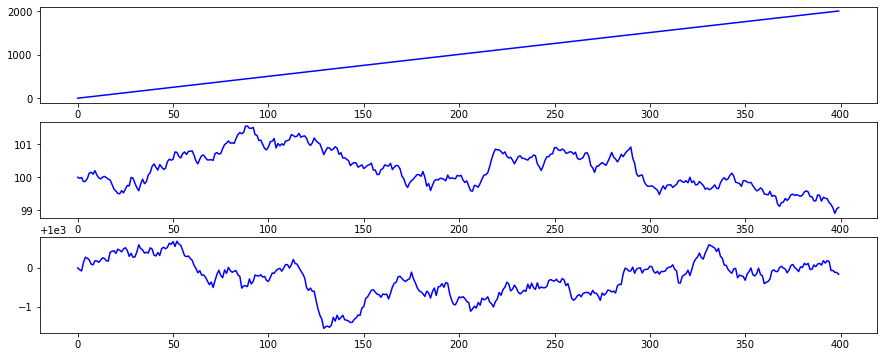

In [152]:
plt.figure(figsize=(15,6))
plt.subplot(311)
plt.plot(res_np[:,0], res_np[:,1], "b-")
plt.subplot(312)
plt.plot(res_np[:,0], res_np[:,2], "b-")
plt.subplot(313)
plt.plot(res_np[:,0], res_np[:,3], "b-")

In [164]:
class EKF:
    def __init__(self, dt, x_init):
        self.dt = dt
        self.x = x_init.reshape(-1, 1)
        self.F = np.array([[1, dt, 0], [0, 1, 0], [0, 0, 1]])
        self.P = np.identity(3) * 50;
        self.Q = np.array([[1.5625e-07, 6.2500e-06, 0], [6.2500e-06, 2.5000e-04, 0], [0, 0, 0.1]])
        
        self.H = np.zeros((1,3))
        self.K = np.zeros((3,2))
        self.R = np.diag([5 ** 2])
    
    def predict(self):
        self.x = self.F @ self.x
        self.P = self.F @ self.P @ self.F + self.Q
        
    def update(self, z):
        z = z.reshape(-1,1)
        temp = np.sqrt(self.x[0] **2 + self.x[2]**2)
        self.H = np.array([self.x[0]/temp, 0, self.x[2]/temp], dtype=float).reshape(1, -1)
        hx = temp
        self.y = z - hx
        self.K = self.P @ self.H.transpose() @ np.linalg.pinv(self.H @ self.P @ self.H.transpose() + self.R)
        self.x = self.x + self.K @ y
        self.P = (np.identity(3) - self.K @ self.H) @ self.P

In [165]:
pred = [[0, 0, 0] for _ in range(400)]
x_init = np.array([0, 100, 1000])
predictor = EKF(0.05, x_init)
for i in range(400):
    predictor.update(res_np[i,-1])
    pred[i] = [predictor.x[0], predictor.x[1], predictor.x[2]]
    predictor.predict()

<ipython-input-164-9217d272d488>:20: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  self.H = np.array([self.x[0]/temp, 0, self.x[2]/temp], dtype=float).reshape(1, -1)


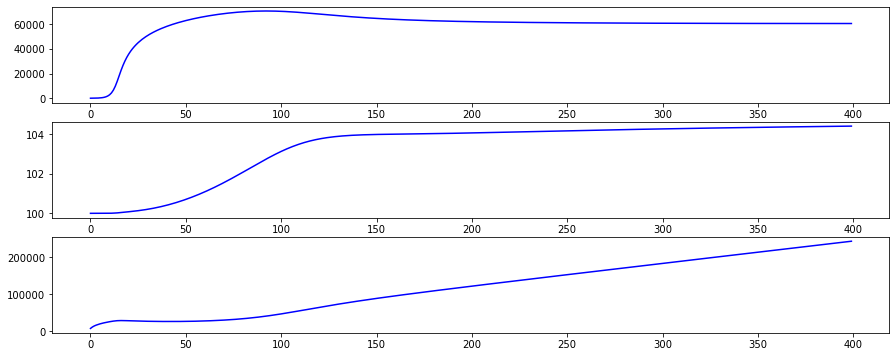

In [166]:
pred_np = np.array(pred)
plt.figure(figsize=(15,6))
plt.subplot(311)
plt.plot(res_np[:,0], pred_np[:,0], "b-")
plt.subplot(312)
plt.plot(res_np[:,0], pred_np[:,1], "b-")
plt.subplot(313)
plt.plot(res_np[:,0], pred_np[:,2], "b-")